# Stable Diffusion LoRA Fine-tuning: Персонализация персонажа Чебурашка

## Описание проекта

**Цель**: Дообучение диффузионной модели Stable Diffusion v1.5 с использованием LoRA для генерации изображений кастомного персонажа `<cheburashka>` с сохранением качества и минимизацией артефактов.

**Основные задачи**:
1. Настроить архитектуру LoRA-адаптера поверх UNet и реализовать процесс обучения с использованием шедулера диффузии
2. Провести серию экспериментов с гиперпараметрами обучения (`train_steps`, `lr`, `snr_gamma`) для оценки влияния на сходимость и визуальное качество
3. Исследовать влияние параметров инференса (`guidance_scale`) на количество артефактов и стабильность генераций
4. Сравнить результаты экспериментов по кривым лосса и визуальным примерам на фиксированном наборе промптов и seed-ов

**О датасете**:  
Обучающий набор содержит **3 изображения** целевого персонажа Чебурашка с индивидуальными текстовыми описаниями:

```python
captions = [
    "<cheburashka>, close-up portrait, huge round furry ears, soft brown and beige fur, standing in a cozy kids playroom, blue walls with glowing stars, colorful space-themed drawings on the easel and walls",
    "<cheburashka>, full body, waving hand, friendly smile, big expressive eyes, standing on light stone pavement, wooden stage behind, several folded wooden director-style chairs with dark fabric seats and backs",
    "<cheburashka>, full body, holding a bright orange with both paws, standing in snowy winter city square, wide staircase with railings behind, decorative street lamps and monumental sculptures in the distance, frosty trees and icy patterns in the cold blue background"
]
```
---

## Содержание

1. [Подготовка окружения и данных](#1-подготовка-окружения-и-данных)
2. [Работа с данными и демонстрация работы сырой модели](#2-работа-с-данными-и-демонстрация-работы-сырой-модели)
3. [Дообучение модели](#3-дообучение-модели)
4. [Демонстрация результатов](#4-демонстрация-результатов)
5. [Заключение](#5-заключение)

---

## 1 Подготовка окружения и данных

In [2]:
# =============================================================================
# Глобальный конфиг (инициализируется один раз в начале ноутбука)
# =============================================================================

# Базовые библиотеки
import warnings
import random
from pathlib import Path

# Обработка данных и визуализация
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

# Основной DL‑стек
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel, AutoencoderKL
from peft import LoraConfig, get_peft_model
from accelerate import Accelerator
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import gc

# Подавление лишних предупреждений и настройка внешнего вида графиков
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# Фиксация случайных сидов для воспроизводимости результатов
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Определение вычислительного устройства и инициализация Accelerator
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
accelerator = Accelerator()

# Базовые пути проекта: данные, модели, эксперименты
PROJECT_ROOT = Path(".").resolve()
DATA_ROOT = PROJECT_ROOT / "data"
MODELS_ROOT = PROJECT_ROOT / "models"
EXPERIMENTS_ROOT = PROJECT_ROOT / "experiments"

for p in [DATA_ROOT, MODELS_ROOT, EXPERIMENTS_ROOT]:
    p.mkdir(parents=True, exist_ok=True)

print(f"DATA_ROOT: {DATA_ROOT}")
print(f"MODELS_ROOT: {MODELS_ROOT}")
print(f"EXPERIMENTS_ROOT: {EXPERIMENTS_ROOT}")

DATA_ROOT: C:\practicum_cv\diffusion_finetuning\data
MODELS_ROOT: C:\practicum_cv\diffusion_finetuning\models
EXPERIMENTS_ROOT: C:\practicum_cv\diffusion_finetuning\experiments


## 2. Работа с данными и демонстрация работы сырой модели

### 2.1.  Загрузка и визуализация данных

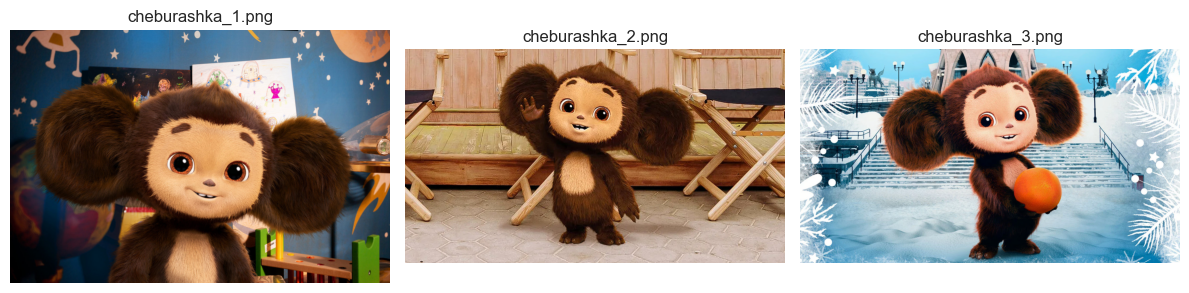

In [10]:
images_dir = DATA_ROOT
image_names = ["cheburashka_1.png", "cheburashka_2.png", "cheburashka_3.png"]
image_paths = [images_dir / name for name in image_names]

for p in image_paths:
    assert p.exists(), f"Файл не найден: {p}"

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, img_path in zip(axes, image_paths):
    img = Image.open(img_path).convert("RGB")
    ax.imshow(img)
    ax.set_title(img_path.name)
    ax.axis("off")

plt.tight_layout()
plt.show()

### 2.2. Создание класса датасета

In [11]:
class ImageDataset(Dataset):
    def __init__(self, img_dir: Path, transform=None):
        """
        Датасет, который возвращает пару (изображение, индекс).
        Важно: файлы сортируются по имени, чтобы индекс совпадал с порядком в массиве эмбеддингов.
        """
        self.img_dir = img_dir
        self.img_paths = sorted([
            p for p in img_dir.iterdir() 
            if p.suffix.lower() in [".jpg", ".jpeg", ".png"]
        ])
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        path = self.img_paths[idx]
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        # Возвращаем image и его индекс, чтобы потом подтянуть нужный промпт
        return image, idx


In [12]:
# Стандартные трансформации для SD 1.5
train_transforms = transforms.Compose([
    transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(512),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

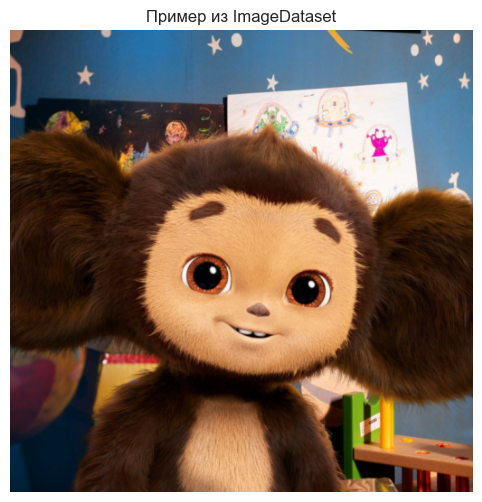

In [13]:
# Визуализация первого элемента датасета
dataset = ImageDataset(DATA_ROOT, transform=train_transforms)

# Визуализация первого элемента датасета
sample, idx = dataset[0]          # берем картинку и индекс
sample_vis = sample * 0.5 + 0.5   # денормировка в [0, 1]

plt.imshow(sample_vis.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.title(f"Пример из ImageDataset")
plt.show()

### 2.3. Генерация оригинальной моделью

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: C:\Users\Ilia\.cache\huggingface\hub\models--runwayml--stable-diffusion-v1-5\snapshots\451f4fe16113bff5a5d2269ed5ad43b0592e9a14\text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: C:\Users\Ilia\.cache\huggingface\hub\models--runwayml--stable-diffusion-v1-5\snapshots\451f4fe16113bff5a5d2269ed5ad43b0592e9a14\safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  0%|          | 0/30 [00:00<?, ?it/s]

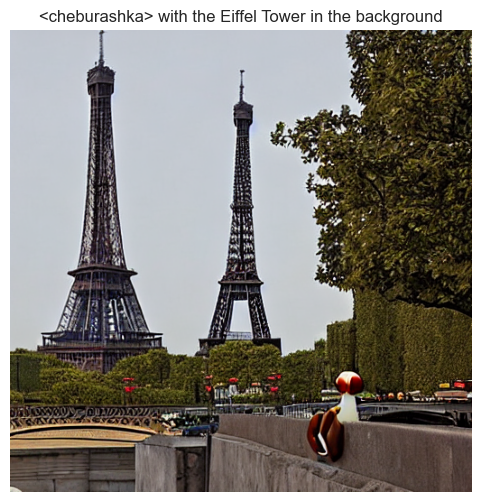

In [14]:
# Генерация изображения базовой моделью без дообучения на LoRA
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
).to(DEVICE)

prompt = "<cheburashka> with the Eiffel Tower in the background"

with torch.autocast(DEVICE if DEVICE == "cuda" else "cpu"):
    image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(prompt)
plt.show()

### 2.4. Кодирование промпта и сохранение эмбеддингов

In [15]:
captions = [
    "<cheburashka>, close-up portrait, huge round furry ears, soft brown and beige fur, standing in a cozy kids playroom, blue walls with glowing stars, colorful space-themed drawings on the easel and walls", # для cheburashka_1
    "<cheburashka>, full body, waving hand, friendly smile, big expressive eyes, standing on light stone pavement, wooden stage behind, several folded wooden director-style chairs with dark fabric seats and backs", # для cheburashka_2
    "<cheburashka>, full body, holding a bright orange with both paws, standing in snowy winter city square, wide staircase with railings behind, decorative street lamps and monumental sculptures in the distance, frosty trees and icy patterns in the cold blue background", # для cheburashka_3
]

# Кодируем каждый промпт отдельно
prompt_embeds_list = []
for caption in captions:
    # encode_prompt возвращает кортеж, берем [0] -> тензор [1, 77, 768]
    emb = pipe.encode_prompt(
        caption,
        DEVICE,
        num_images_per_prompt=1,
        do_classifier_free_guidance=False,
    )[0]
    prompt_embeds_list.append(emb.detach().cpu()) # Сразу на CPU, чтобы не занимать память

# Собираем в один тензор [3, 77, 768]
all_prompts_tensor = torch.cat(prompt_embeds_list, dim=0)

TEXT_EMBEDS_DIR = MODELS_ROOT / "text_embeds"
TEXT_EMBEDS_DIR.mkdir(parents=True, exist_ok=True)
emb_path = TEXT_EMBEDS_DIR / "cheburashka_individual_embeds.pt"

torch.save(all_prompts_tensor, emb_path)
print(f"Сохранены эмбеддинги {all_prompts_tensor.shape} в {emb_path}")

Сохранены эмбеддинги torch.Size([3, 77, 768]) в C:\practicum_cv\diffusion_finetuning\models\text_embeds\cheburashka_individual_embeds.pt


### 2.5. Очистка памяти

In [16]:
del pipe
gc.collect()
torch.cuda.empty_cache()

### 2.6. Общие выводы о работе модели до дообучения

#### Выполненные шаги

В рамках анализа работы базовой диффузионной модели без дообучения были выполнены следующие шаги:

1. **Подготовка данных** — загружены три изображения Чебурашки из фильма, проверено их наличие в `DATA_ROOT` и выполнена визуализация первого примера из `ImageDataset` в ноутбуке после денормировки из диапазона `[-1, 1]` в `[0, 1]`.  
2. **Создание датасета** — реализован класс `ImageDataset`, который загружает изображения из указанной директории, сортирует файлы по имени, ресайзит их до 512×512, применяет аугментации (включая случайное горизонтальное отражение) и нормирует тензор с `mean=std=0.5`, приводя данные к формату, ожидаемому Stable Diffusion.  
3. **Проверка базовой модели** — собран `StableDiffusionPipeline` на основе `runwayml/stable-diffusion-v1-5` и сгенерировано изображение по промпту `"<cheburashka> with the Eiffel Tower in the background"` без подключения LoRA‑адаптера.  
4. **Кодирование текстового промпта** — с помощью метода `encode_prompt` закодирован текст `"<cheburashka> plushie"`, полученные текстовые эмбеддинги сохранены на диск для дальнейшего использования при обучении LoRA.

---

#### Наблюдения по работе модели до обучения

- Базовая модель `runwayml/stable-diffusion-v1-5` **не умеет генерировать Чебурашку**: при запросе `"<cheburashka> with the Eiffel Tower in the background"` получается изображение без узнаваемого персонажа из мультфильма, а токен `<cheburashka>` фактически игнорируется или интерпретируется как неизвестное слово.  
- При использовании других промптов с `<cheburashka>` наблюдается аналогичное поведение: модель создаёт абстрактного персонажа, который не похож на оригинального героя из фильма и визуально не соответствует предоставленным референсным изображениям.  
- На момент начала экспериментов **концепт Чебурашки отсутствует в пространстве текстовых и визуальных представлений модели**, что делает дообучение LoRA на небольшом специализированном датасете обоснованной и необходимой процедурой.


## 3. Дообучение модели

### 3.1. Загрузка моделей

In [17]:
base_model_id = "runwayml/stable-diffusion-v1-5"

# Загрузка шедулера диффузионного процесса
noise_scheduler = DDPMScheduler.from_pretrained(
    base_model_id,
    subfolder="scheduler",
)

# Загрузка VAE для преобразования между пикселями и латентным пространством
vae = AutoencoderKL.from_pretrained(
    base_model_id,
    subfolder="vae",
    torch_dtype=torch.float16,
).to(DEVICE)

# Загрузка базового UNet, поверх которого будут обучаться LoRA-адаптеры
unet = UNet2DConditionModel.from_pretrained(
    base_model_id,
    subfolder="unet",
    torch_dtype=torch.float16,
).to(DEVICE)

# Заморозка весов VAE и базового UNet: градиенты считаются только для LoRA-слоёв
vae.requires_grad_(False)
unet.requires_grad_(False)

print("Модели загружены:")
print("  noise_scheduler:", type(noise_scheduler))
print("  vae:", type(vae))
print("  unet:", type(unet))

Модели загружены:
  noise_scheduler: <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>
  vae: <class 'diffusers.models.autoencoders.autoencoder_kl.AutoencoderKL'>
  unet: <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>


### 3.2. Добавление LoRA 

In [18]:
LORA_RANK = 128

lora_config = LoraConfig(
    r=LORA_RANK,
    lora_alpha=LORA_RANK,
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    init_lora_weights="gaussian",
)

# Оборачивание UNet в PEFT-модель с подключёнными LoRA-адаптерами
unet_lora = get_peft_model(unet, lora_config)

# Подсчёт общего числа параметров и количества обучаемых (приходятся только на LoRA-слои)
trainable_params = 0
all_params = 0
for _, p in unet_lora.named_parameters():
    num = p.numel()
    all_params += num
    if p.requires_grad:
        trainable_params += num

print(f"Всего параметров UNet c LoRA: {all_params/1e6:.2f}M")
print(f"Обучаемых параметров (LoRA): {trainable_params/1e6:.2f}M")

Всего параметров UNet c LoRA: 885.03M
Обучаемых параметров (LoRA): 25.51M


### 3.3. Пайплайн дообучения

In [19]:
# Инициализация TensorBoard-логгера для отслеживания лосса и других метрик обучения LoRA
writer = SummaryWriter(log_dir=str(EXPERIMENTS_ROOT / "cheburashka_lora"))

In [20]:
# Загрузка эмбеддингов
emb_path = TEXT_EMBEDS_DIR / "cheburashka_individual_embeds.pt"

prompt_embeds = torch.load(emb_path).to(DEVICE).to(dtype=torch.float16)

print(f"Форма prompt_embeds: {prompt_embeds.shape}") 

Форма prompt_embeds: torch.Size([3, 77, 768])


In [21]:
# Создание DataLoader
dataset = ImageDataset(DATA_ROOT, transform=train_transforms)

train_batch_size = 1  

train_dataloader = DataLoader(
    dataset,
    batch_size=train_batch_size,
    num_workers=0,
)

# Проверка: достанем один батч, чтобы убедиться
sample_img, sample_idx = next(iter(train_dataloader))
print(f"Батч картинок: {sample_img.shape}")
print(f"Батч индексов: {sample_idx}") 

Батч картинок: torch.Size([1, 3, 512, 512])
Батч индексов: tensor([0])


In [22]:
# Функция для расчёта SNR (для snr_gamma)

def compute_snr(noise_scheduler, timesteps: torch.Tensor) -> torch.Tensor:
    """
    Возвращает SNR для каждого таймстепа.
    SNR = alpha^2 / sigma^2, где alpha - коэффициент сигнала, sigma - шума.
    """
    # Получаю скаляры alpha и sigma для заданных timestep
    alphas_cumprod = noise_scheduler.alphas_cumprod.to(timesteps.device)
    alphas = alphas_cumprod[timesteps]
    sigmas = 1 - alphas
    snr = alphas / sigmas
    return snr

In [23]:
def train_lora(
    vae: AutoencoderKL,
    noise_scheduler: DDPMScheduler,
    unet_lora: UNet2DConditionModel,
    train_dataloader: DataLoader,
    prompt_embeds: torch.Tensor,
    device: torch.device,
    train_steps: int = 1000,
    lr: float = 2e-5,
    max_grad_norm: float = 1.0,
    snr_gamma: float = 5.0,
    save_every: int = 500,
    checkpoints_dir: Path | None = None,
    log_dir: Path | None = None,
):
    """
    Обучение LoRA для SD 1.5 (обучаются только LoRA-слои внутри UNet).
    """

    # Оптимизатор по обучаемым параметрам (LoRA-адаптерам)
    optimizer = torch.optim.AdamW(
        [p for p in unet_lora.parameters() if p.requires_grad],
        lr=lr,
    )
    # Скейлер для обучения в полуплавающей точности (mixed precision)
    scaler = torch.cuda.amp.GradScaler()

    unet_lora.train()
    vae.eval()  # VAE используется только для прямого прохода, его веса заморожены

    # Директория для сохранения LoRA-чекпоинтов
    if checkpoints_dir is None:
        checkpoints_dir = MODELS_ROOT / "lora_checkpoints"
    checkpoints_dir.mkdir(parents=True, exist_ok=True)

    # Директория для логов TensorBoard
    if log_dir is None:
        log_dir = EXPERIMENTS_ROOT / "cheburashka_lora"
    log_dir.mkdir(parents=True, exist_ok=True)
    # Логгер для записи значения лосса по шагам обучения
    writer = SummaryWriter(log_dir=str(log_dir))

    global_step = 0
    losses = []
    progress_bar = tqdm(range(train_steps), desc="Training steps")

    # Перенос всех текстовых эмбеддингов на нужное устройство заранее
    all_prompt_embeds = prompt_embeds.to(device).to(dtype=torch.float16)

    # Основной цикл обучения по шагам
    while global_step < train_steps:
        # Итерации по батчам изображений из датасета
        for batch_images, batch_indices in train_dataloader:
            if global_step >= train_steps:
                break

            # Перенос батча картинок и индексов на устройство
            batch_images = batch_images.to(device, dtype=torch.float16)
            batch_indices = batch_indices.to(device)
            bsz = batch_images.shape[0]

            with torch.autocast(device_type="cuda", dtype=torch.float16):
                # 1) Кодирование картинок в латентное пространство с помощью VAE
                with torch.no_grad():
                    latents = vae.encode(batch_images).latent_dist.sample() * 0.18215

                # 2) Сэмплирование случайных шагов диффузии t для каждого элемента батча
                timesteps = torch.randint(
                    0,
                    noise_scheduler.config.num_train_timesteps,
                    (bsz,),
                    device=device,
                    dtype=torch.long,
                )

                # 3) Генерация гауссовского шума и зашумление латентов согласно выбранным t
                noise = torch.randn_like(latents)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # 4) Выбор текстовых эмбеддингов для текущих картинок по их индексам
                cond_embeds = torch.index_select(all_prompt_embeds, 0, batch_indices)

                # 5) Прогон зашумленных латентов через UNet+LoRA с условием по тексту
                noise_pred = unet_lora(
                    noisy_latents,
                    timesteps,
                    encoder_hidden_states=cond_embeds,
                ).sample

                # 6) Базовый лосс: MSE между предсказанным и истинным шумом
                base_loss = F.mse_loss(noise_pred, noise, reduction="none")
                base_loss = base_loss.mean(dim=list(range(1, base_loss.ndim)))  # [bsz]

                # 7) Дополнительное взвешивание лосса по Min-SNR (если включено)
                if snr_gamma is not None and snr_gamma > 0:
                    snr = compute_snr(noise_scheduler, timesteps)
                    gamma = torch.full_like(snr, snr_gamma)
                    loss_weights = torch.minimum(snr, gamma) / snr
                    loss = (base_loss * loss_weights).mean()
                else:
                    loss = base_loss.mean()

            # Шаг счётчика глобальных шагов обучения
            global_step += 1

            # Обратное распространение ошибки с учётом mixed precision
            scaler.scale(loss).backward()

            # Клиппинг градиентов для стабилизации обучения
            if max_grad_norm is not None and max_grad_norm > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(
                    [p for p in unet_lora.parameters() if p.requires_grad],
                    max_grad_norm,
                )

            # Обновление параметров LoRA-слоёв
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            # Сохранение значения лосса и обновление прогресс-бара
            loss_value = loss.item()
            losses.append(loss_value)
            progress_bar.update(1)
            progress_bar.set_postfix({"loss": loss_value})

            # Логирование лосса в TensorBoard
            writer.add_scalar("loss/train", loss_value, global_step)

            # Периодическое сохранение чекпоинтов LoRA
            if global_step % save_every == 0 or global_step == train_steps:
                ckpt_dir = checkpoints_dir / f"step_{global_step}"
                ckpt_dir.mkdir(parents=True, exist_ok=True)
                unet_lora.save_pretrained(ckpt_dir)
                print(f"\nСохранён LoRA чекпоинт: {ckpt_dir}")

    writer.close()
    return {"losses": losses}

#### Базовая конфигурация

In [24]:
results_baseline = train_lora(
    vae=vae,
    noise_scheduler=noise_scheduler,
    unet_lora=unet_lora,
    train_dataloader=train_dataloader,
    prompt_embeds=prompt_embeds,
    device=DEVICE,
    train_steps=1000,
    lr=2e-5,
    max_grad_norm=1.0,
    snr_gamma=5.0,
    save_every=500,
    checkpoints_dir=MODELS_ROOT / "lora_checkpoints_baseline",
    log_dir=EXPERIMENTS_ROOT / "cheburashka_lora_baseline",
)

Training steps:   0%|          | 0/1000 [00:00<?, ?it/s]


Сохранён LoRA чекпоинт: C:\practicum_cv\diffusion_finetuning\models\lora_checkpoints_baseline\step_500

Сохранён LoRA чекпоинт: C:\practicum_cv\diffusion_finetuning\models\lora_checkpoints_baseline\step_1000


In [25]:
gc.collect()
torch.cuda.empty_cache()

#### Эксперимент 1

Гипотеза: увеличение количества шагов обучения до 2000 улучшит узнаваемость Чебурашки и стабильность генераций по разным промптам.

Изменение:
- `train_steps = 2000` (остальные гиперпараметры те же, что в базовом запуске).

In [26]:
results_steps2000 = train_lora(
    vae=vae,
    noise_scheduler=noise_scheduler,
    unet_lora=unet_lora,
    train_dataloader=train_dataloader,
    prompt_embeds=prompt_embeds,
    device=DEVICE,
    train_steps=2000,
    lr=2e-5,
    max_grad_norm=1.0,
    snr_gamma=5.0,
    save_every=500,
    checkpoints_dir=MODELS_ROOT / "lora_checkpoints_steps2000",
    log_dir=EXPERIMENTS_ROOT / "cheburashka_lora_steps2000",
)

Training steps:   0%|          | 0/2000 [00:00<?, ?it/s]


Сохранён LoRA чекпоинт: C:\practicum_cv\diffusion_finetuning\models\lora_checkpoints_steps2000\step_500

Сохранён LoRA чекпоинт: C:\practicum_cv\diffusion_finetuning\models\lora_checkpoints_steps2000\step_1000

Сохранён LoRA чекпоинт: C:\practicum_cv\diffusion_finetuning\models\lora_checkpoints_steps2000\step_1500

Сохранён LoRA чекпоинт: C:\practicum_cv\diffusion_finetuning\models\lora_checkpoints_steps2000\step_2000


In [27]:
gc.collect()
torch.cuda.empty_cache()

#### Эксперимент 2

Гипотеза: уменьшение скорости обучения сделает обучение более стабильным и уменьшит шум в лоссе, что может немного улучшить качество изображения.

Изменение:
- `lr = 1e-5` вместо `2e-5` (остальные гиперпараметры без изменений).


In [28]:
results_lr1e5 = train_lora(
    vae=vae,
    noise_scheduler=noise_scheduler,
    unet_lora=unet_lora,
    train_dataloader=train_dataloader,
    prompt_embeds=prompt_embeds,
    device=DEVICE,
    train_steps=1000,
    lr=1e-5,
    max_grad_norm=1.0,
    snr_gamma=5.0,
    save_every=500,
    checkpoints_dir=MODELS_ROOT / "lora_checkpoints_lr1e5",
    log_dir=EXPERIMENTS_ROOT / "cheburashka_lora_lr1e5",
)

Training steps:   0%|          | 0/1000 [00:00<?, ?it/s]


Сохранён LoRA чекпоинт: C:\practicum_cv\diffusion_finetuning\models\lora_checkpoints_lr1e5\step_500

Сохранён LoRA чекпоинт: C:\practicum_cv\diffusion_finetuning\models\lora_checkpoints_lr1e5\step_1000


In [29]:
gc.collect()
torch.cuda.empty_cache()

#### Эксперимент 3

Гипотеза: изменение параметра `snr_gamma` повлияет на баланс между шагами с сильным и слабым шумом и может улучшить сходимость.

Вариант 3a:
- `snr_gamma = 2.0` вместо `5.0`.

Вариант 3b:
- `snr_gamma = None` (отключаю SNR‑reweighting, считаю обычный MSE‑лосс).


In [30]:
results_snr2 = train_lora(
    vae=vae,
    noise_scheduler=noise_scheduler,
    unet_lora=unet_lora,
    train_dataloader=train_dataloader,
    prompt_embeds=prompt_embeds,
    device=DEVICE,
    train_steps=1000,
    lr=2e-5,
    max_grad_norm=1.0,
    snr_gamma=2.0,
    save_every=500,
    checkpoints_dir=MODELS_ROOT / "lora_checkpoints_snr2",
    log_dir=EXPERIMENTS_ROOT / "cheburashka_lora_snr2",
)

Training steps:   0%|          | 0/1000 [00:00<?, ?it/s]


Сохранён LoRA чекпоинт: C:\practicum_cv\diffusion_finetuning\models\lora_checkpoints_snr2\step_500

Сохранён LoRA чекпоинт: C:\practicum_cv\diffusion_finetuning\models\lora_checkpoints_snr2\step_1000


In [31]:
gc.collect()
torch.cuda.empty_cache()

In [32]:
results_snrNone = train_lora(
    vae=vae,
    noise_scheduler=noise_scheduler,
    unet_lora=unet_lora,
    train_dataloader=train_dataloader,
    prompt_embeds=prompt_embeds,
    device=DEVICE,
    train_steps=1000,
    lr=2e-5,
    max_grad_norm=1.0,
    snr_gamma=None,
    save_every=500,
    checkpoints_dir=MODELS_ROOT / "lora_checkpoints_snrNone",
    log_dir=EXPERIMENTS_ROOT / "cheburashka_lora_snrNone",
)

Training steps:   0%|          | 0/1000 [00:00<?, ?it/s]


Сохранён LoRA чекпоинт: C:\practicum_cv\diffusion_finetuning\models\lora_checkpoints_snrNone\step_500

Сохранён LoRA чекпоинт: C:\practicum_cv\diffusion_finetuning\models\lora_checkpoints_snrNone\step_1000


In [33]:
gc.collect()
torch.cuda.empty_cache()

#### Визуализация кривых лосса

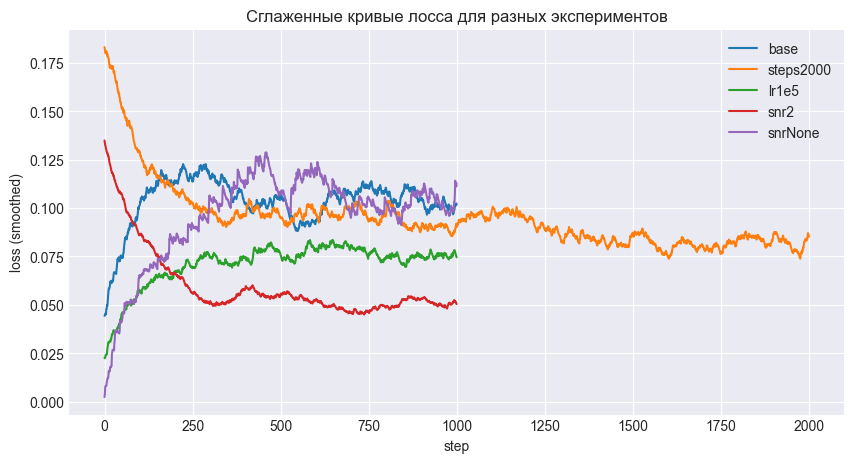

In [34]:
# Экспоненциальное сглаживание
def tb_smooth(values, weight=0.9):
    smoothed = []
    last = values[0]
    for v in values:
        last = last * weight + (1 - weight) * v
        smoothed.append(last)
    return np.array(smoothed)

# Словарь с результатами всех экспериментов
experiments_results = {
    "base":      results_baseline,
    "steps2000": results_steps2000,
    "lr1e5":     results_lr1e5,
    "snr2":      results_snr2,
    "snrNone":   results_snrNone,
}

plt.figure(figsize=(10, 5))

# Построение сглаженных кривых лосса для каждого эксперимента на одном графике
for name, res in experiments_results.items():
    losses = np.array(res["losses"])
    smooth = tb_smooth(losses, weight=0.99)
    steps = np.arange(len(smooth))
    plt.plot(steps, smooth, label=name)

plt.xlabel("step")
plt.ylabel("loss (smoothed)")
plt.grid(True)
plt.legend()
plt.title("Сглаженные кривые лосса для разных экспериментов")
plt.show()

### 3.4. Общие выводы о дообучении модели LoRA

#### Выполненные шаги

В рамках дообучения базовой диффузионной модели с использованием LoRA были выполнены следующие шаги:

1. **Инициализация компонент Stable Diffusion** — загружены шедулер `DDPMScheduler`, автоэнкодер `AutoencoderKL` и базовый `UNet2DConditionModel` из чекпоинта `runwayml/stable-diffusion-v1-5`, веса VAE и базового UNet заморожены, чтобы обучение затрагивало только дополнительные LoRA‑слои.  
2. **Подготовка LoRA‑адаптеров** — поверх UNet настроена конфигурация `LoraConfig` с рангом `r=128` и целевыми модулями `["to_k", "to_q", "to_v", "to_out.0"]`, после чего UNet обёрнут в PEFT‑модель; проверено, что обучаемым остаётся только небольшой процент параметров (порядка нескольких миллионов).  
3. **Настройка текста и данных для обучения** — сформированы индивидуальные текстовые описания для трёх обучающих изображений, закодированы через `encode_prompt` в тензор эмбеддингов и организован датасет `ImageDataset`, возвращающий пары `(изображение, индекс)`, что обеспечивает корректное сопоставление картинки и её текстового описания на каждом шаге.  
4. **Организация процесса обучения** — реализована функция `train_lora`, в которой изображения переводятся в латентное пространство VAE, зашумляются в соответствии со случайно выбранным диффузионным временем, а UNet+LoRA обучается предсказывать добавленный шум по зашумленным латентам и текстовым эмбеддингам.  
5. **Исследование гиперпараметров** — проведена серия экспериментов с изменением числа шагов обучения (`1000` → `2000`), скорости обучения (`2e-5` → `1e-5`) и параметра Min‑SNR‑взвешивания (`snr_gamma = 5.0`, `2.0`, `None`), результаты каждого эксперимента сохранены и визуализированы в виде сглаженных кривых лосса.  

---

#### Наблюдения по результатам дообучения

- Дообучение LoRA позволяет внедрить в модель новый визуальный концепт: после обучения генерации с токеном `<cheburashka>` начинают содержать персонажа с крупными ушами и характерной цветовой палитрой, заметно более близкого к референсам, чем в базовой модели без адаптера.  
- Кривые лосса показывают, что не все конфигурации одинаково эффективны: уменьшение learning rate до `1e-5` и изменение схемы Min‑SNR‑взвешивания (`snr2`, `snrNone`) приводят к более низким и стабильным значениям лосса по сравнению с базовым запуском и простым увеличением числа шагов.  
- При фиксированном небольшом датасете (три изображения) ключевое влияние на качество дообучения оказывают выбор скорости обучения и параметра `snr_gamma`; увеличение числа шагов без настройки этих гиперпараметров даёт меньший прирост.  
- В целом дообучение LoRA на специализированном датасете позволяет встроить новый персонаж в пространство признаков Stable Diffusion и добиться генераций, которые лучше соответствуют целевому образу и реагируют на текстовые промпты с токеном `<cheburashka>`.

## 4. Демонстрация результатов

In [ ]:
from diffusers import StableDiffusionPipeline
from peft import LoraConfig, get_peft_model
import torch
from pathlib import Path

# Конфигурация
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODELS_ROOT = Path("models")
EXPERIMENTS_ROOT = Path("experiments")
SEED = 10102005 

prompts = [
    "<cheburashka> with the Eiffel Tower in the background",
    "<cheburashka> plushie",
    "<cheburashka> in sketch style",
    "<cheburashka> riding a bicycle",
]

experiments = {
    "baseline": MODELS_ROOT / "lora_checkpoints_baseline" / "step_1000",
    "steps2000": MODELS_ROOT / "lora_checkpoints_steps2000" / "step_2000",
    "lr1e5": MODELS_ROOT / "lora_checkpoints_lr1e5" / "step_1000",
    "snr2": MODELS_ROOT / "lora_checkpoints_snr2" / "step_1000",
    "snrNone": MODELS_ROOT / "lora_checkpoints_snrNone" / "step_1000"
}

# Инициализация базовой модели
print("Загрузка базовой модели SD 1.5...")
base_model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
).to(DEVICE)
pipe.unet.requires_grad_(False)

# Инициализация PEFT
lora_config = LoraConfig(
    r=128,
    lora_alpha=128,
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    init_lora_weights="gaussian",
)
pipe.unet = get_peft_model(pipe.unet, lora_config)

def generate_for_experiment(exp_name: str, ckpt_dir: Path, pipeline):
    print(f"\n=== Эксперимент: {exp_name} ===")
    
    try:
        pipeline.unet.load_adapter(str(ckpt_dir), adapter_name=exp_name)
        pipeline.unet.set_adapter(exp_name)
    except Exception as e:
        print(f"Ошибка загрузки адаптера {ckpt_dir}: {e}")
        return []

    out_dir = EXPERIMENTS_ROOT / f"cheburashka_lora_{exp_name}"
    out_dir.mkdir(parents=True, exist_ok=True)

    images = []
    for i, prompt in enumerate(prompts, start=1):
        generator = torch.Generator(device=DEVICE).manual_seed(SEED + i)

        with torch.autocast(DEVICE):
            img = pipeline(
                prompt,
                num_inference_steps=60,
                guidance_scale=7.5,
                generator=generator,
                height=512,
                width=512,
            ).images[0]

        img_path = out_dir / f"{i:02d}.png"
        img.save(img_path)
        images.append((prompt, img_path))
        print(f"  [{exp_name}] {prompt} -> {img_path}")
    
    # Очищаем адаптер после использования
    pipeline.unet.delete_adapter(exp_name)
    return images

# Запуск
all_results = {}
for exp_name, ckpt_dir in experiments.items():
    if ckpt_dir.exists():
        all_results[exp_name] = generate_for_experiment(exp_name, ckpt_dir, pipe)
    else:
        print(f"Чекпоинт не найден: {ckpt_dir}")


In [10]:
# Сравнительный анализ изображений
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

exp_names = [name for name in experiments.keys() if name in all_results]
n_rows = len(exp_names)
n_cols = len(prompts)

def plot_comparison_grid(filename: str = "cheburashka_comparison.png"):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

    for row, exp_name in enumerate(exp_names):
        for col, (prompt, img_path) in enumerate(all_results[exp_name]):
            img = Image.open(img_path).convert("RGB")
            ax = axes[row, col] if n_rows > 1 else axes[col]
            ax.imshow(img)
            if row == 0:
                ax.set_title(prompt, fontsize=8)
            if col == 0:
                ax.set_ylabel(exp_name, fontsize=10)
            ax.axis("off")

    plt.tight_layout()

    out_path = RESULTS_DIR / filename
    plt.savefig(out_path, dpi=150)
    print(f"Сравнительная сетка сохранена в {out_path}")
    plt.close(fig)

plot_comparison_grid("output_diff7.5.png")

Сравнительная сетка сохранена в results\output_diff7.5.png


#### Эксперимент: влияние `guidance_scale` на качество генерации (CFG)

**Рисунок 1 — `guidance_scale = 7.5`**  
![](results/output_diff7.5.png)

При `guidance_scale = 7.5` заметно усиливается влияние текста на генерацию, но вместе с этим чаще появляются артефакты на мордочке и шерсти (пересветы, «ломаные» детали), а часть кадров выглядит более «жёсткой» по цветам и контрасту. Кроме того, из-за высокого значения CFG чаще срабатывает встроенный фильтр безопасности (Safety Checker), что приводит к появлению полностью черных изображений вместо результатов генерации.

---

**Рисунок 2 — `guidance_scale = 5.0`**  
![](results/output_diff5.0.png)

При `guidance_scale = 5.0` генерации выглядят более естественно и устойчиво: мордочка и текстуры шерсти чаще остаются аккуратными, а общий стиль получается мягче при сохранении узнаваемости персонажа.

---

#### Общие выводы по экспериментам и гипотезам

- Эксперименты 1–2–3a показали улучшение сходимости (лосс снижался быстрее и/или был стабильнее по сравнению с базовым запуском), однако заметное улучшение визуального качества генераций наблюдалось лишь в Эксперименте 1 (увеличение числа шагов до 2000).
- Для Эксперимента 3b (отключение SNR‑reweighting) наблюдается ухудшение как сходимости, так и качества изображений: лосс менее стабильный, а артефактов и деградаций деталей больше.
- Эксперимент с `guidance_scale` показывает, что «стандартное» значение (7.5) не всегда оптимально: в нашем случае более низкое значение (`5.0`) даёт визуально более качественные и стабильные результаты.
- Итоговое качество генераций определяется не только процессом обучения LoRA (и динамикой лосса), но и корректным подбором параметров инференса, особенно силой classifier‑free guidance.
- Таким образом, финальное качество следует оценивать по визуальным примерам на фиксированных seed и промптах (и одинаковых настройках сэмплинга), а не только по величине лосса на обучении.


## 5. Заключение

### Итоги работы

- Реализовано дообучение диффузионной модели Stable Diffusion v1.5 с использованием LoRA на трёх изображениях целевого персонажа `<cheburashka>`: настроена архитектура адаптера LoRA поверх UNet, подготовлены текстовые промпты и организован процесс обучения через шедулер диффузии.
- Проведена серия экспериментов с ключевыми гиперпараметрами обучения (`train_steps`, `lr`, `snr_gamma`) и параметрами инференса (`guidance_scale`), с сохранением чекпоинтов, логов обучения и визуальных результатов в структурированную директорию `diffusion_finetuning/`.
- Настроен единый протокол визуальной оценки: генерации по фиксированному набору промптов и seed‑ов для всех конфигураций, сбор сеток изображений и анализ кривых лосса, что позволило сопоставлять сходимость обучения и визуальное качество между экспериментами.

### Сравнение экспериментов

Результаты серии экспериментов с различными конфигурациями обучения LoRA:

| Эксперимент | Конфигурация | Сходимость лосса | Визуальное качество | Артефакты |
|-------------|--------------|------------------|---------------------|-----------|
| Baseline | `steps=1000`, `lr=2e-5`, `snr_gamma=5.0` | Базовая | Хорошее | Минимум |
| Exp 1 | `steps=2000`, `lr=2e-5`, `snr_gamma=5.0` | Улучшена | **Заметно лучше** | Минимум |
| Exp 2 | `steps=1000`, `lr=1e-5`, `snr_gamma=5.0` | Улучшена | Незначительно лучше | Умеренно |
| Exp 3a | `steps=1000`, `lr=2e-5`, `snr_gamma=2.0` | Улучшена | Незначительно лучше | Умеренно |
| Exp 3b | `steps=1000`, `lr=2e-5`, `snr_gamma=None` | **Хуже** | **Хуже** | Много |

### Выводы по обучению LoRA

#### Сходимость и качество

**Эксперименты 1, 2, 3a** демонстрируют **улучшение сходимости по лоссу**:
- Кривые лосса становятся более гладкими и достигают меньших значений по сравнению с базовой конфигурацией
- **Эксперимент 1** (увеличение числа шагов до 2000) показывает **существенное улучшение визуального качества**: узнаваемость Чебурашки и консистентность образа по разным промптам заметно растут при минимальном числе артефактов
- **Эксперименты 2 и 3a** дают лишь **незначительное улучшение качества изображений**: картинки становятся немного стабильнее, но часть артефактов и нестабильностей сохраняется

**Эксперимент 3b** (отключение Min‑SNR‑взвешивания) приводит к **ухудшению результатов**:
- Лосс колеблется сильнее, сходимость замедлена
- На изображениях появляется больше шумов, искажений и «ломаных» деталей

#### Влияние параметров инференса

**Эксперимент с `guidance_scale`** показывает критическую роль параметров сэмплинга:
- Стандартное значение **7.5** не является универсально оптимальным и часто приводит к артефактам
- При **`guidance_scale = 5.0`** генерации содержат меньше артефактов, выглядят мягче и стабильнее по серии промптов
- Высокие значения CFG усиливают следование тексту ценой пересатурации и неестественных деталей

### Практические рекомендации

- **Для текущего датасета** наилучший баланс между сходимостью и визуальным качеством дают конфигурации с увеличенным числом шагов обучения (2000) и активным Min‑SNR‑взвешиванием (`snr_gamma` в районе 2–5)
- **При инференсе** рекомендуется использовать пониженный `guidance_scale` (около 5) и фиксировать остальные параметры сэмплера для минимизации артефактов и обеспечения устойчивого стиля персонажа
- **Лосс остаётся важным диагностическим сигналом**, однако окончательный выбор модели следует делать по визуальным примерам на фиксированном наборе промптов и seed‑ов; метрики сходимости и качество изображений необходимо рассматривать совместно